In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import sys
import os
from tqdm.notebook import tqdm
from itertools import permutations
import torch
import torch.nn.functional as F
from librosa.core import resample
EPS = 1e-8

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
old_sr = 8000
new_sr = 8000
half = False
root = '../'

In [2]:
device = 3
device_ids = [3]
torch.cuda.set_device(device)

In [3]:
def load(filename):
    samples = np.load(filename)/(2**15)
    samples = resample(samples, old_sr, new_sr)
    # pad the samples
    if len(samples)>2*new_sr:
        samples = samples[:2*new_sr]
    if len(samples)<2*new_sr:
        padding = np.zeros(2*new_sr-len(samples))
        samples = np.concatenate([samples, padding])
    return samples


def make_spectrogram(segment):
    segment = segment[50:-50] # make size 200
    S = np.abs(librosa.stft(segment, n_fft = 255, hop_length = 125)) # 32 ms window, 16 ms hop
    return S

66.24841 0.2562074 0.44970217


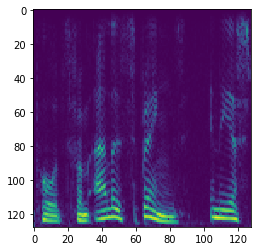

In [4]:
def find_max2(tensor):
    array = tensor.cpu().detach().numpy()
    max2 = []
    for row in array:
        max2.append(np.argsort(row)[::-1][:2])
    return np.array(max2)

def compute_corrects(tensor1, tensor2):
    max_1, max_2 = find_max2(tensor1), find_max2(tensor2)
    batch_size = max_1.shape[0]
    batch_corrects = 0
    for i in range(batch_size):
        if Counter(max_1[i])==Counter(max_2[i]):
            batch_corrects+=1
    return batch_corrects

def compute_correct(tensor1, tensor2):
    tensor1, tensor2 = tensor1.cpu().detach().numpy(), tensor2.cpu().detach().numpy()
    batch_size = tensor1.shape[0]
    batch_corrects = 0
    for i in range(batch_size):
        if np.argmax(tensor1[i]) == np.argmax(tensor2[i]):
            batch_corrects += 1
    return batch_corrects

class IDset(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.segments = pd.read_csv(root+csv)
        self.speakers = list(set(self.segments['speaker']))
        self.speakers.sort()
        self.spkr2idx = {spkr:i for i, spkr in enumerate(self.speakers)}
        self.segments_by_speakers = \
        {speaker:self.segments[self.segments['speaker']==speaker] for speaker in self.speakers}

    def __len__(self):
        return len(self.segments)
    def __getitem__(self, idx):
        segment = self.segments.iloc[idx]
        speaker = segment['speaker']
        spkr_idx = self.spkr2idx[speaker]
        signal = np.load(root+segment['segfile'])
        spec = np.log(1+make_spectrogram(signal))[None, ...]
        target = np.zeros(len(self.speakers))
        target[spkr_idx] = 1
        return spec, target

trainset = IDset('train-segments.csv')
valset = IDset('val-segments.csv')
#testset = IDset('test-segments.csv')

spec, target = valset[6]
print(np.linalg.norm(spec), spec.mean(), spec.std())
plt.imshow(spec[0][::-1])

In [5]:
def cross_entropy(input, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(-target * torch.log(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * torch.log(input), dim=1))

In [6]:
class DRNN(nn.Module):

    def __init__(self, n_input, n_hidden, n_layers, dropout=0, cell_type='LSTM', bidirectional = True, batch_first=False):
        super(DRNN, self).__init__()

        self.dilations = [2 ** i for i in range(n_layers)] # 2^(n_layers-1)
        self.cell_type = cell_type
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        layers = []
        if self.cell_type == "GRU":
            cell = nn.GRU
        elif self.cell_type == "RNN":
            cell = nn.RNN
        elif self.cell_type == "LSTM":
            cell = nn.LSTM
        else:
            raise NotImplementedError

        for i in range(n_layers):
            if i == 0:
                c = cell(n_input, n_hidden, dropout=dropout, bidirectional = bidirectional)
            else:
                if bidirectional:
                    c = cell(n_hidden*2, n_hidden, dropout=dropout, bidirectional = bidirectional)
                else:
                    c = cell(n_hidden, n_hidden, dropout=dropout, bidirectional = bidirectional)
            layers.append(c)
        self.cells = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        outputs = []
        for i, (cell, dilation) in enumerate(zip(self.cells, self.dilations)):
            if hidden is None:
                inputs, _ = self.drnn_layer(cell, inputs, dilation)
            else:
                inputs = self.dropout(inputs)
                inputs, hidden[i] = self.drnn_layer(cell, inputs, dilation, hidden[i])

            outputs.append(inputs[-dilation:])

        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        return inputs, outputs

    def drnn_layer(self, cell, inputs, rate, hidden=None): # rate means dilation
        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        inputs, _ = self._pad_inputs(inputs, n_steps, rate) # does nothing on even inputs
        dilated_inputs = self._prepare_inputs(inputs, rate) # different phases concatenated in batch dimension

        if hidden is None:
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size)
        else:
            hidden = self._prepare_inputs(hidden, rate)
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size, hidden=hidden)

        splitted_outputs = self._split_outputs(dilated_outputs, rate)
        outputs = self._unpad_outputs(splitted_outputs, n_steps)

        return outputs, hidden

    def _apply_cell(self, dilated_inputs, cell, batch_size, rate, hidden_size, hidden=None):
        if hidden is None: # init to zeros
            if self.cell_type == 'LSTM':
                c, m = self.init_hidden(batch_size * rate, hidden_size)
                if self.bidirectional:
                    hidden = (c.unsqueeze(0).repeat(2, 1, 1), m.unsqueeze(0).repeat(2, 1, 1))
                else:
                    hidden = (c.unsqueeze(0), m.unsqueeze(0))
            else:
                hidden = self.init_hidden(batch_size * rate, hidden_size).unsqueeze(0)

        dilated_outputs, hidden = cell(dilated_inputs, hidden)

        return dilated_outputs, hidden

    def _unpad_outputs(self, splitted_outputs, n_steps):
        return splitted_outputs[:n_steps]

    def _split_outputs(self, dilated_outputs, rate):
        # dilated_outputs.shape = L, batch*rate, n_hidden
        batchsize = dilated_outputs.size(1) // rate

        blocks = [dilated_outputs[:, i * batchsize: (i + 1) * batchsize, :] for i in range(rate)] # [rate, L, batch, n_hidden]

        interleaved = torch.stack((blocks)).transpose(1, 0).contiguous() # [L, rate, batch, n_hidden]
        interleaved = interleaved.view(dilated_outputs.size(0) * rate, 
                                       batchsize,
                                       dilated_outputs.size(2))
        return interleaved

    def _pad_inputs(self, inputs, n_steps, rate):
        is_even = (n_steps % rate) == 0

        if not is_even:
            dilated_steps = n_steps // rate + 1

            zeros_ = torch.zeros(dilated_steps * rate - inputs.size(0),
                                 inputs.size(1),
                                 inputs.size(2))
            if use_cuda:
                zeros_ = zeros_.cuda(device)

            inputs = torch.cat((inputs, zeros_))
        else:
            dilated_steps = n_steps // rate

        return inputs, dilated_steps

    def _prepare_inputs(self, inputs, rate):
        dilated_inputs = torch.cat([inputs[j::rate, :, :] for j in range(rate)], 1)
        return dilated_inputs

    def init_hidden(self, batch_size, hidden_dim):
        hidden = torch.zeros(batch_size, hidden_dim).cuda(device)
        if self.cell_type == "LSTM":
            memory = torch.zeros(batch_size, hidden_dim).cuda(device)
            return (hidden, memory)
        else:
            return hidden
        

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size, stride, padding = (kernel_size-1)//2, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out


In [8]:
load_model = True
n_hidden = 800
n_layers = 3
num_heads = 4
dropout = 0.3

model_to_load = 'models/best-idnet-lstm-splice.pth'
# class IDnet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.drnn = DRNN(n_input = 128, n_hidden = n_hidden, n_layers = n_layers, dropout = dropout) # receptive field 32 frames
#         self.mha =  nn.MultiheadAttention(n_hidden*2, num_heads = num_heads, dropout = dropout, bias=True) # L * batch * 64
#         self.fc = nn.Linear(n_hidden*2, 20)
#         self.softmax = nn.Softmax(-1)
#         self.clamp = Lambda(lambda x: x.clamp(min = 1e-8))
#     def forward(self, X):
#         # X : [batch_size, 1, F, L]
#         X = X.squeeze(dim = 1).permute(2, 0, 1) # [batch_size, F, L] -> [L, batch_size, F]
#         X, _ = self.drnn(X) # [L, batch_size, n_hidden]
#         X, _ = self.mha(X, X, X) # [L, batch_size, n_hidden]
#         X = self.fc(X) # [L, batch_size, n_speakers]
#         X = self.softmax(X) # [L, batch_size, n_speakers]
#         X = self.clamp(X) # [L, batch_size, n_speakers]
#         X = X.mean(dim = 0) # [batch_size, n_speakers]
#         return X

# len_slice = 20
# shift = 1
# class IDnet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         #self.lstm = nn.LSTM(input_size = 128, hidden_size = n_hidden, num_layers = n_layers, dropout = dropout, bidirectional = True)# receptive field 32 frames
#         #self.mha =  nn.MultiheadAttention(n_hidden*2, num_heads = num_heads, dropout = dropout, bias=True) # L * batch * 64
#         self.fc1 = nn.Linear(len_slice*128, n_hidden)
#         self.fc2 = nn.Linear(n_hidden, n_hidden)
#         self.fc3 = nn.Linear(n_hidden, 20)
#         self.softmax = nn.Softmax(-1)
#         self.clamp = Lambda(lambda x: x.clamp(min = 1e-8))
#         self.use_all_chunks = True
#         self.act = nn.ReLU()
        
#     def forward(self, X):
#         # [batch_size, 1, F, L]
#         X = X.squeeze(dim = 1).permute(2, 0, 1) # [L, batch_size, F]
#         X = self.chop_chunk(X)
#         out = self.estimate(X)
#         return out
    
#     def predict_chunk(self, chunk):
#         # chunk size : [len_slice, batch_size, F]
#         X = chunk.permute(1, 0, 2).contiguous().view(chunk.shape[1], -1) # [batch_size, n_hidden*len_slice]
#         X = self.act(self.fc1(X))
#         X = self.act(self.fc2(X))
#         X = self.fc3(X)
#         X = self.softmax(X)
#         X = self.clamp(X)
#         return X
        
#     def chop_chunk(self, spec):
#         # [L, batch_size, F]
#         n_frames, batch_size, n_feats = spec.shape
#         N_slices=(n_frames-len_slice)//shift
#         chunks = []
#         for i in range(N_slices):
#             chunks.append(spec[i*shift:i*shift+len_slice]) # list of N_fr elements, each (batch_size*wlen)
#         return chunks
    
#     def estimate(self, chunks):
#         out_vecs = []
#         if not self.use_all_chunks:
#             indices = np.random.randint(len(chunks), size = (len(chunks)//30))
#             chunks = [chunks[idx] for idx in indices]
#         for chunk in chunks:
#             out_vecs.append(self.predict_chunk(chunk)) # list of N_fr elements, each (batch_size*N_spkr), softmaxed
#         out_tensor = torch.stack(out_vecs, dim = 1) # batch_size*N_fr*N_spkr
#         out_tensor = out_tensor.mean(dim = 1) # batch_size*N_spkr
#         return out_tensor 

# class IDnet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.res1 = ResidualBlock(1, 64, 5)
#         self.mp1 = nn.MaxPool2d(2)
#         self.res2 = ResidualBlock(64, 128, 3)
#         self.mp2 = nn.MaxPool2d(2)
#         self.res3 = ResidualBlock(128, 256, 3)
#         self.mp3 = nn.MaxPool2d(2)
#         self.res4 = ResidualBlock(256, 512, 3)
#         self.mp4 = nn.MaxPool2d(2)
#         self.res5 = ResidualBlock(512, 1024, 3)
#         self.pool = nn.AdaptiveMaxPool2d(1)
#         self.fc = nn.Linear(1024, 20)
#         self.softmax = nn.Softmax(-1)
#     def forward(self, X):
#         X = self.mp1(self.res1(X))
#         X = self.mp2(self.res2(X))
#         X = self.mp3(self.res3(X))
#         X = self.mp4(self.res4(X))
#         X = self.pool(self.res5(X))
#         X = X.view(X.shape[0], -1)
#         X = self.fc(X)
#         X = self.softmax(X)
#         X = X.clamp(min = 1e-8)
#         return X
    
len_slice = 20
shift = 1
class IDnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = 128, hidden_size = 200, num_layers = n_layers, dropout = dropout, bidirectional = True)# receptive field 32 frames
        #self.mha =  nn.MultiheadAttention(n_hidden*2, num_heads = num_heads, dropout = dropout, bias=True) # L * batch * 64
        self.fc1 = nn.Linear(len_slice*200*2, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, 20)
        self.softmax = nn.Softmax(-1)
        self.clamp = Lambda(lambda x: x.clamp(min = 1e-8))
        self.use_all_chunks = True
        self.act = nn.ReLU()
        
    def forward(self, X):
        # [batch_size, 1, F, L]
        X = X.squeeze(dim = 1).permute(2, 0, 1) # [L, batch_size, F]
        X = self.chop_chunk(X)
        out = self.estimate(X)
        return out
    
    def predict_chunk(self, chunk):
        # chunk size : [len_slice, batch_size, F]
        X = chunk
        X, _ = self.lstm(X)
        #X = self.mha(X)
        X = X.permute(1, 0, 2).contiguous().view(X.shape[1], -1) # [batch_size, n_hidden*len_slice]
        X = self.act(self.fc1(X))
        X = self.act(self.fc2(X))
        X = self.fc3(X)
        X = self.softmax(X)
        X = self.clamp(X)
        return X
        
    def chop_chunk(self, spec):
        # [L, batch_size, F]
        n_frames, batch_size, n_feats = spec.shape
        N_slices=(n_frames-len_slice)//shift
        chunks = []
        for i in range(N_slices):
            chunks.append(spec[i*shift:i*shift+len_slice]) # list of N_fr elements, each (batch_size*wlen)
        return chunks
    
    def estimate(self, chunks):
        out_vecs = []
        if not self.use_all_chunks:
            indices = np.random.randint(len(chunks), size = (len(chunks)//30))
            chunks = [chunks[idx] for idx in indices]
        for chunk in chunks:
            out_vecs.append(self.predict_chunk(chunk)) # list of N_fr elements, each (batch_size*N_spkr), softmaxed
        out_tensor = torch.stack(out_vecs, dim = 1) # batch_size*N_fr*N_spkr
        out_tensor = out_tensor.mean(dim = 1) # batch_size*N_spkr
        return out_tensor 
    
    
    
    
    
idnet = IDnet().cuda(device)
    
# tune hidden layers smaller if overfit
optimizer = torch.optim.Adam(idnet.parameters(), 0.0002, weight_decay = 0)

if load_model and os.path.exists(model_to_load):
    print('load model')
    checkpoint = torch.load(model_to_load)
    idnet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    bestacc = checkpoint['bestacc']
else:
    print('initializing new model')
    bestacc = 0.0

print(bestacc)

load model
0.9789268292682927


ConvNet -> 0.96<br>
Splicing(1 train chunk, 200 nodes) -> 0.96<br>
Splicing(1 train chunk, 800 nodes) -> 0.94<br>
Splicing(1 train chunk, 3layerLSTM200nodes, 3layers of fc800 nodes, dropout0.3) -> 0.97<br>
Drnn 800 nodes -> 0.95

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
def cross_entropy(input, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(-target * torch.log(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * torch.log(input), dim=1))
criterion = cross_entropy

for epoch in range(64):
    idnet.train()
    running_loss = 0.0
    running_accuracy = 0.0
    idnet.use_all_chunks = False
    for batch_idx, (spec, target) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        spec = spec.float().cuda(device)
        target = target.float().cuda(device)
        pred = idnet(spec)
        
        loss = criterion(pred, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(idnet.parameters(), 0.1)
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += compute_correct(pred, target)/batch_size

        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200, running_accuracy / 200))
            running_loss = 0.0
            running_accuracy = 0.0
            torch.save({
            'model_state_dict': idnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'bestacc': bestacc
            }, 'models/idnet.pth')
            
    
    idnet.eval()
    idnet.use_all_chunks = True
    with torch.no_grad():
        corrects = 0
        for batch_idx, (spec, target) in enumerate(tqdm(valloader)):
            spec = spec.float().cuda(device)
            target = target.float().cuda(device)            
            pred = idnet(spec)

            corrects += compute_correct(pred, target)

        print('val acc:', corrects/len(valset))
        if corrects/len(valset) > bestacc:
            bestacc = corrects/len(valset)
            torch.save({
            'model_state_dict': idnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'bestacc': bestacc
            }, 'models/best-idnet.pth')


66.443214 0.30979553 0.41650772
['andrea_arsenault', 'brian_lamb', 'csp_waj_susan', 'david_brancaccio', 'eddie_mair', 'joie_chen', 'kathleen_kennedy', 'leon_harris', 'linda_wertheimer', 'linden_soles', 'lisa_mullins', 'lou_waters', 'lynn_vaughan', 'mark_mullen', 'natalie_allen', 'noah_adams', 'peter_jennings', 'robert_siegel', 'ted_koppel', 'thalia_assuras']
['andrea_arsenault', 'brian_lamb', 'csp_waj_susan', 'david_brancaccio', 'eddie_mair', 'joie_chen', 'kathleen_kennedy', 'leon_harris', 'linda_wertheimer', 'linden_soles', 'lisa_mullins', 'lou_waters', 'lynn_vaughan', 'mark_mullen', 'natalie_allen', 'noah_adams', 'peter_jennings', 'robert_siegel', 'ted_koppel', 'thalia_assuras']


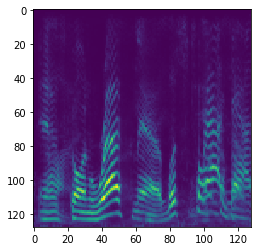

In [10]:
class IDset_separated(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.overlays = pd.read_csv(csv)
        self.speakers = list(set(self.overlays['first_speaker']))
        self.speakers.sort()
        self.spkr2idx = {spkr:i for i, spkr in enumerate(self.speakers)}

    def __len__(self):
        return len(self.overlays)
    def __getitem__(self, idx):
        overlay = self.overlays.iloc[idx]
        spkr1, spkr2 = overlay['first_speaker'], overlay['second_speaker']
        
        spec1 = np.load(overlay['first_file'])[None, ...]
        spec2 = np.load(overlay['second_file'])[None, ...]
        
        target1, target2 = np.zeros(len(self.speakers)), np.zeros(len(self.speakers))
        target1[self.spkr2idx[spkr1]], target2[self.spkr2idx[spkr2]] = 1, 1
        return spec1, spec2, target1, target2

model_to_load = 'models/best-idnet-lstm-splice.pth'
checkpoint = torch.load(model_to_load)
idnet.load_state_dict(checkpoint['model_state_dict'])
testset = IDset_separated('separated-test.csv')
spec1, spec2, target1, target2 = testset[6]
plt.imshow(spec1[0][::-1])
print(np.linalg.norm(spec1), spec1.mean(), spec1.std())
print(testset.speakers)
print(valset.speakers)

In [13]:
batch_size = 32
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
corrects = 0
idnet.eval()
idnet.use_all_chunks = True
for batch_idx, (spec1, spec2, target1, target2) in enumerate(tqdm(testloader)):
    spec1, spec2 = spec1.float().cuda(device), spec2.float().cuda(device)
    target1, target2 = target1.float().cuda(device), target2.float().cuda(device)            
    pred1, pred2 = idnet(spec1), idnet(spec2)
    pred = torch.stack([pred1, pred2], dim=0)
    pred, _= torch.max(pred, dim=0)
    corrects += compute_corrects(pred, target1+target2)
print('test acc:', corrects/len(testset))



test acc: 0.7748855835240275
